# Exploratory Data Analysis – Economic Stress and Social Media Usage

This notebook presents the main exploratory data analysis (EDA) for the project:

> **Economic Stress and Digital Behavior: How Economic Changes Shape Social Media Usage in Europe**

The goal is to visually inspect how macro–economic conditions (inflation, unemployment and consumer confidence)
relate to social–media participation, and how platform preferences shift across time.

The notebook is organised as follows:

1. **Setup and data loading**  
2. **Descriptive statistics and sanity checks**  
3. **Economic stress vs social–media participation (H1)**  
4. **Consumer confidence as a moderator (H2 – visual intuition)**  
5. **Monthly platform dynamics and category shifts (H3)**  

All plots use a consistent colour scheme and readable labels so that they can be exported directly into the report.

In [1]:
# ============================================================
# 1. Setup and data loading
# ============================================================
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look consistent across the notebook
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Project paths (adapt to your local structure if needed)
PROJECT_ROOT = Path.home() / "Desktop" / "DSA210"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "figures" / "eda"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Using processed data from:", DATA_PROCESSED)

# Load annual panel (panel_a)
annual_candidates = ["panel_annual_final.csv", "panel_annual.csv"]
panel_a = None
for fname in annual_candidates:
    path = DATA_PROCESSED / fname
    if path.exists():
        print("Loaded annual panel from:", fname)
        panel_a = pd.read_csv(path)
        break

if panel_a is None:
    raise FileNotFoundError("No annual panel file found in data/processed/.")

# Load monthly panel for H3 (panel_m)
monthly_path = DATA_PROCESSED / "panel_monthly_h3.csv"
if not monthly_path.exists():
    raise FileNotFoundError("Monthly panel 'panel_monthly_h3.csv' not found in data/processed/.")

panel_m = pd.read_csv(monthly_path)

print("Annual panel shape :", panel_a.shape)
print("Monthly panel shape:", panel_m.shape)

display(panel_a.head())
display(panel_m.head())

Using processed data from: /Users/ibrahimgozlukaya/Desktop/DSA210/data/processed
Loaded annual panel from: panel_annual_final.csv
Annual panel shape : (424, 15)
Monthly panel shape: (306593, 15)


,geo,year,sm_participation,inflation,unemployment,cci,Facebook,Instagram,YouTube,LinkedIn,ent_share,prof_share,ent_minus_prof,d_sm,stress
0,AL,2018,48.33,NaN,NaN,NaN,79.240833,3.094167,7.065000,0.298333,89.400000,0.298333,89.101667,NaN,NaN
1,AL,2019,52.13,NaN,NaN,NaN,69.003333,5.556667,4.623333,0.275833,79.183333,0.275833,78.907500,3.80,NaN
2,AL,2020,54.80,NaN,NaN,NaN,75.620000,6.143333,3.115000,0.157500,84.878333,0.157500,84.720833,2.67,NaN
3,AL,2021,60.77,NaN,NaN,NaN,91.660833,1.360000,1.035833,0.115833,94.056667,0.115833,93.940833,5.97,NaN
4,AL,2022,64.07,NaN,NaN,NaN,93.218333,1.830000,1.087500,0.140000,96.135833,0.140000,95.995833,3.30,NaN


,geo,year,month,facebook,instagram,youtube,linkedin,unemployment,hicp_index,ent_share,prof_share,d_unemp,d_infl,d_ent,d_prof
0,AL,2010,10,86.40,0.0,11.36,0.03,NaN,NaN,32.586667,0.03,NaN,NaN,NaN,NaN
1,AL,2010,11,87.67,0.0,10.63,0.03,NaN,NaN,32.766667,0.03,NaN,NaN,0.180000,0.00
2,AL,2010,12,87.53,0.0,10.80,0.04,NaN,NaN,32.776667,0.04,NaN,NaN,0.010000,0.01
3,AL,2011,1,90.20,0.0,8.28,0.05,NaN,NaN,32.826667,0.05,NaN,NaN,0.050000,0.01
4,AL,2011,2,88.35,0.0,9.84,0.05,NaN,NaN,32.730000,0.05,NaN,NaN,-0.096667,0.00


## 2. Descriptive statistics and sanity checks

Before focusing on the hypotheses, we check the basic structure of the data:

- coverage over countries and years  
- distributions of social–media participation and economic indicators  
- simple trends over time.

This step is mainly to ensure there are no obvious coding problems and to give a first visual impression of the data.

Number of unique countries (annual): 39
Year range (annual): 2013 - 2024

Summary statistics (annual panel):


,count,mean,std,min,25%,50%,75%,max
sm_participation,423.0,6.068887e+01,12.681398,31.580000,51.685000,60.550000,68.905000,93.820000
inflation,377.0,3.246704e+00,6.478623,-2.534258,0.483843,1.615234,3.674879,64.904002
unemployment,383.0,7.642639e+00,4.166658,2.025000,4.937500,6.541667,8.979167,27.808333
cci,288.0,1.000465e+02,1.934613,94.287252,98.799519,100.224695,101.418100,103.869250
stress,286.0,-2.459571e-15,1.990643,-3.347550,-1.263473,-0.423530,0.645935,11.659260


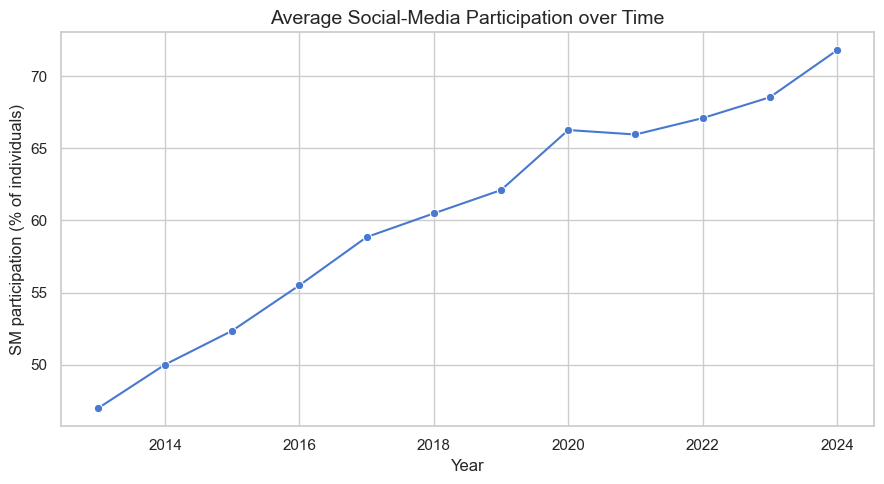

In [2]:
# Basic info
print("Number of unique countries (annual):", panel_a["geo"].nunique())
print("Year range (annual):", panel_a["year"].min(), "-", panel_a["year"].max())

# Summary statistics for key variables
key_cols = ["sm_participation", "inflation", "unemployment", "cci", "stress"]
print("\nSummary statistics (annual panel):")
display(panel_a[key_cols].describe().T)

# Simple time trend of average social media participation
avg_sm = (
    panel_a
    .groupby("year", as_index=False)["sm_participation"]
    .mean()
)

plt.figure()
sns.lineplot(data=avg_sm, x="year", y="sm_participation", marker="o")
plt.title("Average Social-Media Participation over Time")
plt.xlabel("Year")
plt.ylabel("SM participation (% of individuals)")
plt.tight_layout()
plt.savefig(FIG_DIR / "sm_participation_trend.png", dpi=200)
plt.show()

## 3. Economic stress vs social–media participation (H1)

Hypothesis H1 states that **higher economic stress** is associated with **higher social–media participation**.
We use the combined stress index constructed from inflation, unemployment and consumer confidence.

Two complementary visuals are used:

1. A **scatter plot with regression line** of economic stress vs participation.  
2. A **within–country change plot** relating stress to the year–to–year change in participation.

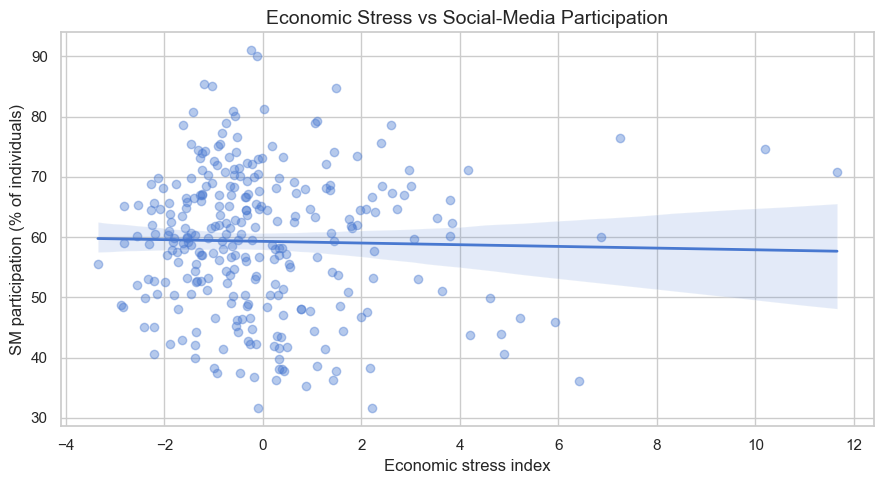

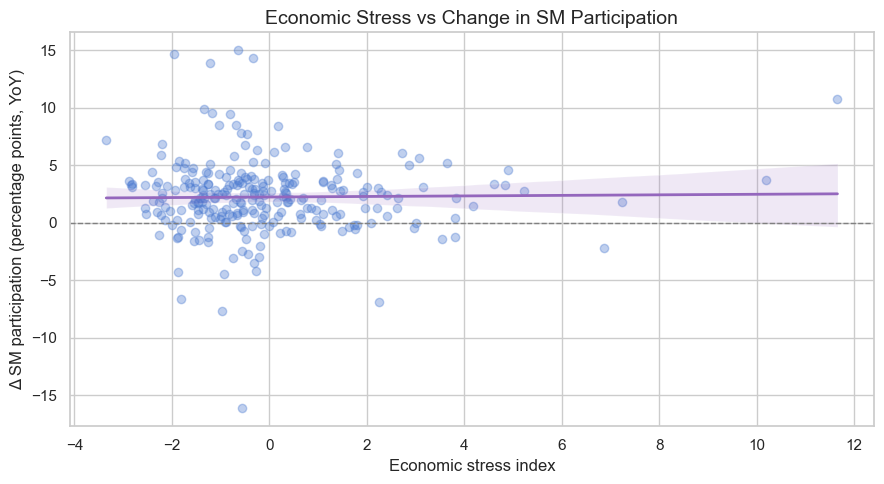

In [3]:
# Ensure stress and sm_participation are available and drop missing
df_h1 = panel_a.dropna(subset=["stress", "sm_participation"]).copy()

plt.figure()
sns.regplot(
    data=df_h1,
    x="stress",
    y="sm_participation",
    lowess=False,
    scatter_kws={"alpha": 0.4},
    line_kws={"linewidth": 2}
)
plt.title("Economic Stress vs Social-Media Participation")
plt.xlabel("Economic stress index")
plt.ylabel("SM participation (% of individuals)")
plt.tight_layout()
plt.savefig(FIG_DIR / "h1_stress_vs_level.png", dpi=200)
plt.show()

# Compute year-to-year change in SM participation within countries
panel_a = panel_a.sort_values(["geo", "year"])
if "d_sm" not in panel_a.columns:
    panel_a["d_sm"] = panel_a.groupby("geo")["sm_participation"].diff()

df_change = panel_a.dropna(subset=["stress", "d_sm"]).copy()

plt.figure()
sns.regplot(
    data=df_change,
    x="stress",
    y="d_sm",
    scatter_kws={"alpha": 0.35},
    line_kws={"color": "tab:purple", "linewidth": 2}
)
plt.title("Economic Stress vs Change in SM Participation")
plt.xlabel("Economic stress index")
plt.ylabel("Δ SM participation (percentage points, YoY)")
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig(FIG_DIR / "h1_stress_vs_change.png", dpi=200)
plt.show()

## 4. Consumer confidence as a moderator (H2 – visual exploration)

H2 suggests that **consumer confidence changes the strength of the relationship** between economic stress
and social–media participation.

To build intuition before formal regression, we use two plots:

1. A **scatter plot** of economic stress vs participation where points are coloured by consumer confidence (CCI).  
2. A **faceted regression plot** comparing the stress–participation relationship in **low vs high confidence** environments
   (median split on CCI).

These visuals mimic the style of earlier EDA attempts while keeping a clean, consistent theme.

                            OLS Regression Results                            
Dep. Variable:                   d_sm   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5665
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.452
Time:                        23:44:31   Log-Likelihood:                -677.81
No. Observations:                 261   AIC:                             1360.
Df Residuals:                     259   BIC:                             1367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2308      0.202     11.053      

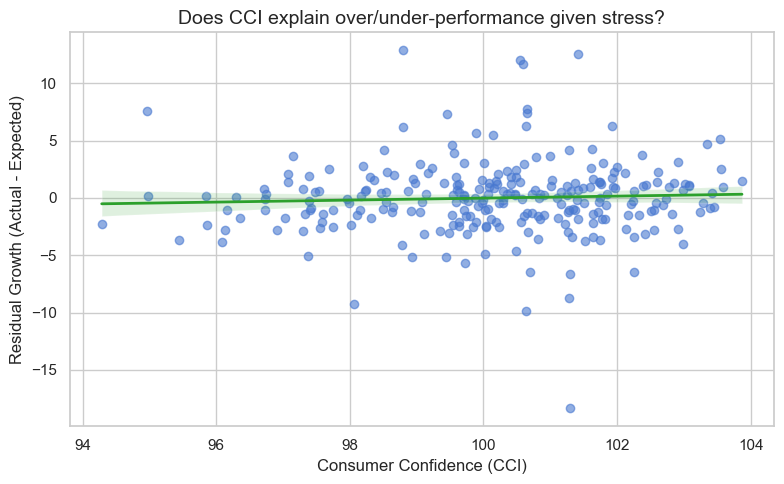

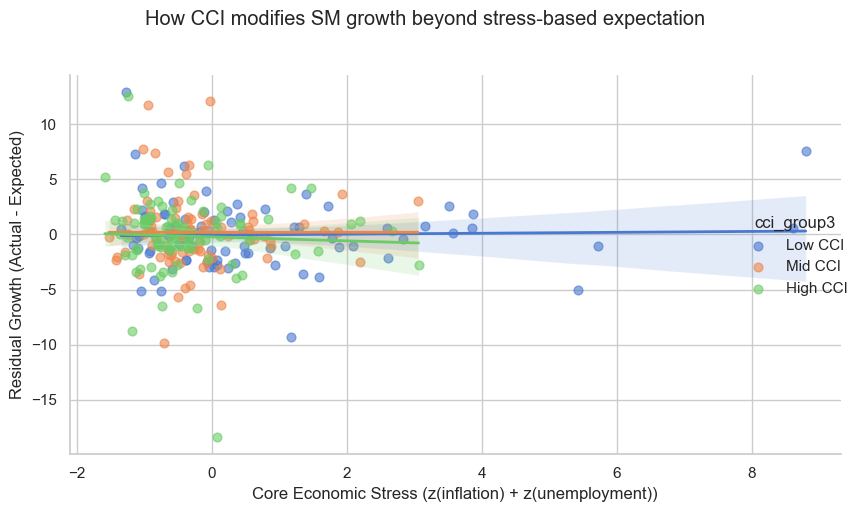

In [5]:
# ============================================================
# H2 – Residual growth plots (CCI as moderator)
# ============================================================

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Ensure yearly change in SM participation is available
panel_a = panel_a.sort_values(["geo", "year"]).copy()
if "d_sm" not in panel_a.columns:
    panel_a["d_sm"] = panel_a.groupby("geo")["sm_participation"].diff()

# 2) Build *core* economic stress (only inflation + unemployment z-scores)
df_h2 = panel_a.dropna(subset=["inflation", "unemployment", "cci", "d_sm"]).copy()

df_h2["infl_z_core"]  = (df_h2["inflation"]    - df_h2["inflation"].mean())    / df_h2["inflation"].std()
df_h2["unemp_z_core"] = (df_h2["unemployment"] - df_h2["unemployment"].mean()) / df_h2["unemployment"].std()
df_h2["core_stress"]  = df_h2["infl_z_core"] + df_h2["unemp_z_core"]

# 3) Regress ΔSM on *core* stress and compute residuals
X = sm.add_constant(df_h2["core_stress"])
y = df_h2["d_sm"]
model_core = sm.OLS(y, X).fit()

df_h2["expected_growth"] = model_core.predict(X)
df_h2["growth_resid"]    = df_h2["d_sm"] - df_h2["expected_growth"]

print(model_core.summary())

# ------------------------------------------------------------
# Plot 1 – Residual growth vs CCI  (sence güzel olan ilk grafik)
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_h2,
    x="cci",
    y="growth_resid",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "tab:green", "linewidth": 2}
)
plt.title("Does CCI explain over/under-performance given stress?")
plt.xlabel("Consumer Confidence (CCI)")
plt.ylabel("Residual Growth (Actual - Expected)")
plt.tight_layout()
plt.savefig(FIG_DIR / "h2_residual_vs_cci.png", dpi=200)
plt.show()

# ------------------------------------------------------------
# Plot 2 – Residual growth vs core stress, coloured by CCI terciles
# ------------------------------------------------------------

# 3 CCI groups (Low / Mid / High)
df_h2["cci_group3"] = pd.qcut(df_h2["cci"], 3, labels=["Low CCI", "Mid CCI", "High CCI"])

g = sns.lmplot(
    data=df_h2,
    x="core_stress",
    y="growth_resid",
    hue="cci_group3",
    height=5,
    aspect=1.5,
    scatter_kws={"alpha": 0.6, "s": 40},
    line_kws={"linewidth": 2}
)
g.set_axis_labels("Core Economic Stress (z(inflation) + z(unemployment))",
                  "Residual Growth (Actual - Expected)")
g.fig.suptitle("How CCI modifies SM growth beyond stress-based expectation", y=1.02)

plt.tight_layout()
g.savefig(FIG_DIR / "h2_residual_vs_stress_by_cci.png", dpi=200)
plt.show()

## 5. Monthly platform dynamics and category shifts (H3)

H3 focuses on whether **economic stress changes which platforms gain attention**.

Using the monthly panel from Statcounter we:

- summarise **entertainment vs professional** platform shares over time, and  
- look at how **monthly changes in unemployment and inflation** are related to
  **monthly changes in platform categories**.

For entertainment, we average Facebook, Instagram and YouTube.  
For professional use, we proxy by LinkedIn.

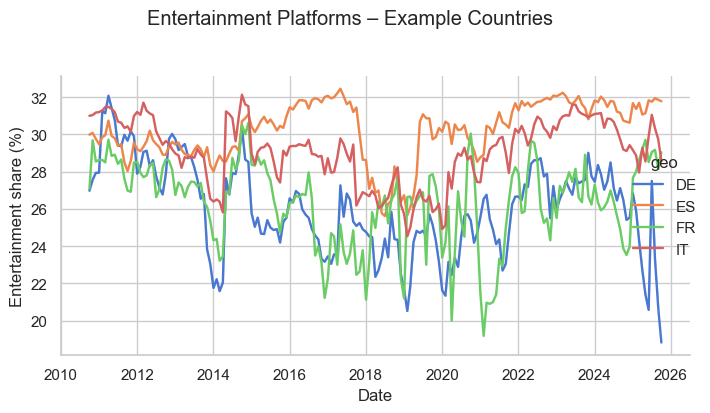

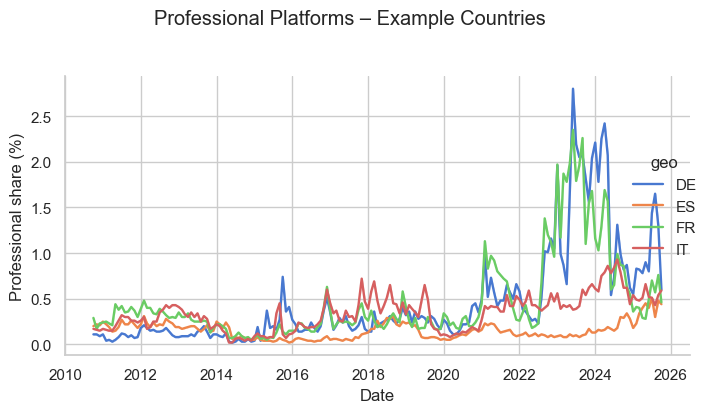

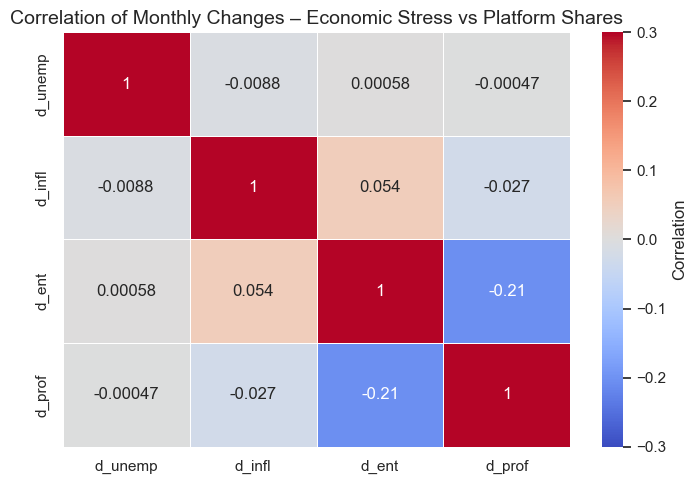

In [6]:
# Make sure the category variables exist; if not, create them
panel_m = panel_m.copy()
if "ent_share" not in panel_m.columns or "prof_share" not in panel_m.columns:
    if set(["facebook", "instagram", "youtube", "linkedin"]).issubset(panel_m.columns):
        panel_m["ent_share"] = panel_m[["facebook", "instagram", "youtube"]].mean(axis=1)
        panel_m["prof_share"] = panel_m["linkedin"]

# Example: pick a few countries and plot entertainment vs professional over time
example_countries = ["DE", "FR", "IT", "ES"]  # adjust if some are missing
mask = panel_m["geo"].isin(example_countries)

# Build a proper datetime index for plotting
panel_m["date"] = pd.to_datetime(dict(year=panel_m["year"], month=panel_m["month"], day=1))

plot_df = panel_m[mask].copy()

g = sns.relplot(
    data=plot_df,
    x="date",
    y="ent_share",
    hue="geo",
    kind="line",
    height=4,
    aspect=1.6,
    linewidth=1.7
)
g.set_axis_labels("Date", "Entertainment share (%)")
g.fig.suptitle("Entertainment Platforms – Example Countries", y=1.03)
plt.tight_layout()
g.savefig(FIG_DIR / "h3_ent_share_examples.png", dpi=200)

g2 = sns.relplot(
    data=plot_df,
    x="date",
    y="prof_share",
    hue="geo",
    kind="line",
    height=4,
    aspect=1.6,
    linewidth=1.7
)
g2.set_axis_labels("Date", "Professional share (%)")
g2.fig.suptitle("Professional Platforms – Example Countries", y=1.03)
plt.tight_layout()
g2.savefig(FIG_DIR / "h3_prof_share_examples.png", dpi=200)

# Monthly change variables (if not already in the file)
panel_m = panel_m.sort_values(["geo", "year", "month"])
if "d_unemp" not in panel_m.columns:
    if "unemployment" in panel_m.columns:
        panel_m["d_unemp"] = panel_m.groupby("geo")["unemployment"].diff()
if "d_infl" not in panel_m.columns:
    if "hicp_index" in panel_m.columns:
        panel_m["d_infl"] = panel_m.groupby("geo")["hicp_index"].diff()
if "d_ent" not in panel_m.columns:
    panel_m["d_ent"] = panel_m.groupby("geo")["ent_share"].diff()
if "d_prof" not in panel_m.columns:
    panel_m["d_prof"] = panel_m.groupby("geo")["prof_share"].diff()

# Correlation matrix for monthly changes
corr_cols = ["d_unemp", "d_infl", "d_ent", "d_prof"]
corr_available = [c for c in corr_cols if c in panel_m.columns]
corr_m = panel_m[corr_available].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_m,
    annot=True,
    cmap="coolwarm",
    vmin=-0.3,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation of Monthly Changes – Economic Stress vs Platform Shares")
plt.tight_layout()
plt.savefig(FIG_DIR / "h3_change_correlations.png", dpi=200)
plt.show()